In [86]:
import ndlib
import networkx as nx
import ndlib.models.epidemics as ep
import json
import ndlib.models.ModelConfig as mc
import numpy as np
import math
import random
import matplotlib.pyplot as plt


from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

## Wikipedia code
Gillespie's Direct Method

In [239]:
# Input parameters ####################

# int; total population
N =300

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = N

# float; rate of infection after contact
beta = 15

# float; rate of cure
gamma = 5

# int; initial infected population
n_I = 5

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = beta * n_S * n_I / V
    w2 = gamma * n_I
    W = w1 + w2

    # generate exponentially distributed random variable dt
    # using inverse transform sampling
    dt = -math.log(1 - random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))

with open("SIR_data.txt", "w+") as fp:
    fp.write("\n".join("%f %i %i %i" % x for x in SIR_data))


from scipy.integrate import odeint
import numpy as np

# Numerical solution using an ordinary differential equation solver
ts = np.linspace(0, 2, num=200)
initial_S_I_R = (N - 5, 5, 0)


def differential_SIR(initial_S_I_R, t, beta, gamma, V):
    n_S, n_I, n_R = initial_S_I_R
    dS_dt = -beta * n_S / V * n_I
    dI_dt = (beta * n_S / V - gamma) * n_I
    dR_dt = gamma * n_I
    return dS_dt, dI_dt, dR_dt


solution = odeint(differential_SIR, initial_S_I_R, ts, args=(beta, gamma, V))
S1, I1, R1 = solution.T

# print(solution)
# print(SIR_data)

n = 0
tg = [x[n] for x in SIR_data]
n = 1
Sg = [x[n] for x in SIR_data]
n = 2
Ig = [x[n] for x in SIR_data]
n = 3
Rg = [x[n] for x in SIR_data]

## from https://en.wikipedia.org/wiki/Gillespie_algorithm

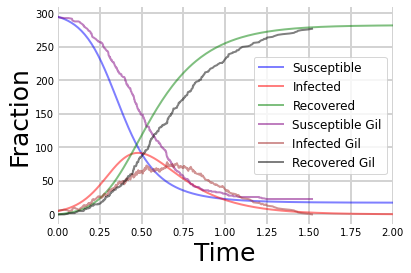

In [240]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(ts, S1, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(ts, I1, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(ts, R1, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(tg, Sg, 'purple', alpha=0.5, lw=2, label='Susceptible Gil')
ax.plot(tg, Ig, 'brown', alpha=0.5, lw=2, label='Infected Gil')
ax.plot(tg, Rg, 'black', alpha=0.5, lw=2, label='Recovered Gil')
ax.set_xlabel('Time', size = 25)
ax.set_ylabel('Fraction', size = 25)
#ax.set_ylim(0,1.2)
ax.set_xlim(0,2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='lightgray', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.legend(fontsize="large")
plt.show()

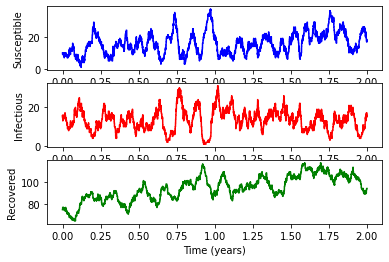

In [312]:
####################################################################
###    This is the PYTHON version of program 6.4 from page 203 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR model (including births and deaths) with full    #
### (event-driven) demographic stochasticity.					   #
###																   #
### This is a more complex stochastic model as 6 events are		   #
### possible: infection, recovery, birth, death of susceptible,    #
### death of infected, death of recovered.					       #
### Note: by default we are using a very small population size 	   #
### to highlight the stochasticity.				   				   #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import numpy as np
import pylab as pl

beta=1.0
gamma=1/10.0
mu=1/70
N0=100
### You may want to try with popylation size of 50 (small) to see the events
### In this case uncomment the next line
#N0=50.0
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
# Y0=10
# X0=4500
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

timestep=0.0

def stoc_eqs(INP,ts): 
	V = INP
	Rate=np.zeros((6))
	Change=np.zeros((6,3))
	N=np.sum(V[range(3)])
	Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0]);
	Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1]);
	Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
	Rate[3] = mu*V[0];  Change[3,:]=([-1, 0, 0]);
	Rate[4] = mu*V[1];  Change[4,:]=([0, -1, 0]);
	Rate[5] = mu*V[2];  Change[5,:]=([0, 0, -1]);
	R1=pl.rand();
	R2=pl.rand();
	ts = -np.log(R2)/(np.sum(Rate));
	list1 = np.cumsum(Rate)
	for i in range(len(list1)):
		if list1[i] >= R1*np.sum(Rate):
			V[range(3)] = V[range(3)]+Change[i,:]
			return [V,ts]


def Stoch_Iteration(INPUT):
	lop=0
	ts=0
	T=[0]
	S=[0]
	I=[0]
	R=[0]
	while T[lop] < ND:
		lop=lop+1
		T.append(T[lop-1]+ts)
		S.append(INPUT[0])
		I.append(INPUT[1])
		R.append(INPUT[2])
		[res,ts] = stoc_eqs(INPUT,ts)
		lop=lop+1
		T.append(T[lop-1])
		S.append(INPUT[0])
		I.append(INPUT[1])
		R.append(INPUT[2])
	return [T,S,I,R]

[T,S,I,R]=Stoch_Iteration(INPUT)

tT=np.array(T)[1:,]/365.
tS=np.array(S)[1:,]
tI=np.array(I)[1:,]
tR=np.array(R)[1:,]

pl.subplot(311)
pl.plot(tT, tS, 'b')
#pl.xlabel ('Time (years)')
pl.ylabel ('Susceptible')
pl.subplot(312)
pl.plot(tT, tI, 'r')
#pl.xlabel ('Time (years)')
pl.ylabel ('Infectious')
pl.subplot(313)
pl.plot(tT, tR, 'g')
pl.xlabel ('Time (years)')
pl.ylabel ('Recovered')
pl.show()

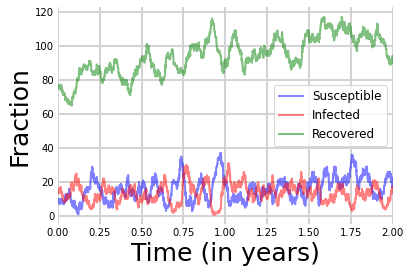

In [314]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(tT, tS, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(tT, tI, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(tT, tR, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time (in years)', size = 25)
ax.set_ylabel('Fraction', size = 25)
#ax.set_ylim(0,1.2)
ax.set_xlim(0,2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='lightgray', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.legend(fontsize="large")
plt.show()